<h1>  Face Image Retrieval Using Content-based Image Retrieval (CBIR) system & Saliency Map </h1>

### Content
1. [Introduce](#introduce)
2. [Load Data](#load-data)
3. [Pre-processing Data](#pre-process)
4. [Model](#model)
5. [SupConLoss](#loss)
6. [Train Model](#train)
7. [Evaluate Model](#evaluate)
8. [Test Model](#test)
9. [Pretrained Model in VGGFace2 dataset](#pretrain)
10. [Visual Explaination with Similarity-based Saliency Map (SBSM)](#saliency)
11. [Face CBIR system - Demo](#demo)
12. [Challenge](#challenge)
13. [Future Improve](#future)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<a name="introduce"></a>
# 1. Introduce

Image Retrieval is a vast field within Computer Vision that deals with finding images that best match a user's query. These images are retrieved from large databases.

Image Retrieval is categorized into various types based on user queries. Common types include:

 - Content-based
 - Text-based
 - ...
 
Image Retrieval finds applications in numerous domains, including but not limited to healthcare, security, entertainment.



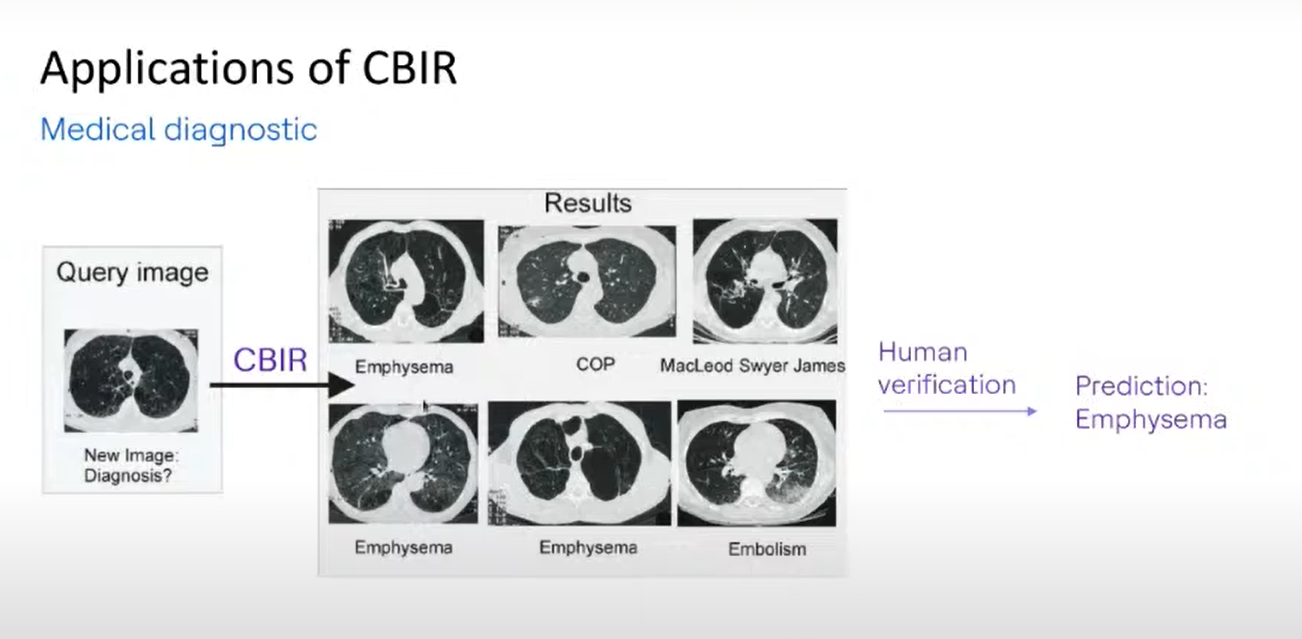

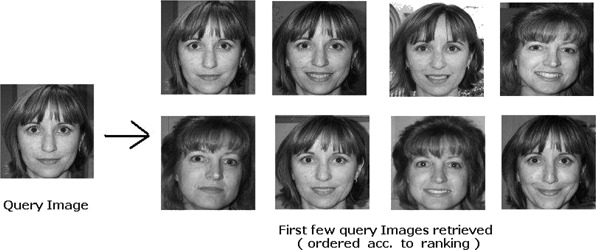

Content-based Image Retrieval System

![](https://ascelibrary.org/cms/10.1061/JCCEE5.CPENG-5473/asset/450e2be0-b56a-44a5-b4d5-1e4472c88389/assets/images/large/figure1.jpg)

<a name="load-data"></a>
# 2. Load Data

Library

In [ ]:
!pip install -q facenet-pytorch faiss-gpu transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
import os
import random
import torchvision
import albumentations as A
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from facenet_pytorch import InceptionResnetV1

In [ ]:
!unzip -q "/content/drive/MyDrive/PRML/img_align_celeba.zip"


In [ ]:
PATH_DIR = './img_align_celeba/'
len(os.listdir(PATH_DIR))

202599

<a name="pre-process"></a>
# 3. Pre-Processing Data


In [ ]:
train_paths = []
val_paths = []
test_paths = []
with open('/content/drive/MyDrive/PRML/list_eval_partition.txt') as f:
    samples = f.readlines()

for sample in samples:
    sample = sample.strip().split()
    if int(sample[1]) == 0:
        train_paths.append(sample[0])
    elif int(sample[1]) == 1:
        val_paths.append(sample[0])
    else:
        test_paths.append(sample[0])

len(train_paths), len(val_paths), len(test_paths)

(162770, 19867, 19962)

In [ ]:
train_dct = {}
val_dct = {}
test_dct = {}
lst_identities = []
with open('/content/drive/MyDrive/PRML/identity_CelebA.txt') as f:
    identities = f.readlines()

for identity in identities:
    img_file, id_ = identity.rstrip().split()
    if img_file in train_paths and int(id_) <= 1000:
        if id_ in train_dct.keys():
            train_dct[id_].append(os.path.join(PATH_DIR, img_file))
        else:
            train_dct[id_] = []
            train_dct[id_].append(os.path.join(PATH_DIR, img_file))

    elif img_file in val_paths:
        if id_ in val_dct.keys():
            val_dct[id_].append(os.path.join(PATH_DIR, img_file))
        else:
            val_dct[id_] = []
            val_dct[id_].append(os.path.join(PATH_DIR, img_file))

    elif img_file in test_paths:
        if id_ in test_dct.keys():
            test_dct[id_].append(os.path.join(PATH_DIR, img_file))
        else:
            test_dct[id_] = []
            test_dct[id_].append(os.path.join(PATH_DIR, img_file))

In [ ]:
len(train_dct.keys())

811

## Data augmentation

In [ ]:
train_transforms = transforms.Compose([
  transforms.Resize((160,160)),
  transforms.AutoAugment(),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomHorizontalFlip(),
  transforms.CenterCrop(160),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
  transforms.Resize((160,160)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dct, split='train', transform = val_transforms):
        super().__init__()
        self.dct = dct
        self.transform = transform
        self.split = split
        self.data = []
        self._prepare_data()



    def _prepare_data(self):
        if self.split == 'train':
            for identity in self.dct['train'].keys():
                for img_path in self.dct['train'][identity]:
                    self.data.append((img_path, int(identity)))


        elif self.split == 'val':
            for identity in self.dct['val'].keys():
                for img_path in self.dct['val'][identity]:
                    self.data.append((img_path, int(identity)))

        else:
            for identity in self.dct['test'].keys():
                for img_path in self.dct['test'][identity]:
                    self.data.append((img_path, int(identity)))



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img2_path = random.choice(self.dct[self.split][str(label)])
        merge_img_path = img_path + '\t' + img2_path
        return merge_img_path, label

In [ ]:
dct = {'train': train_dct, 'val': val_dct, 'test': test_dct}

In [ ]:
train_dataset = MyDataset(dct=dct)
val_dataset = MyDataset(dct=dct, split='val')
test_dataset= MyDataset(dct=dct, split='test')

## Data loader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader= DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(train_dataloader)

270

In [ ]:
len(test_dataloader)

312

<a name="model"></a>
# 4. Model

In [ ]:
from facenet_pytorch import InceptionResnetV1
class SiameseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = InceptionResnetV1(pretrained='vggface2')
    def forward(self, x):
        x = self.backbone(x)
        x = torch.nn.functional.normalize(x, dim=1)
        return x

model = SiameseModel()
rand_img = torch.rand((5,3,160,160))
model(rand_img).shape

torch.Size([5, 512])

<a name="loss"></a>
# 5. SupConLoss

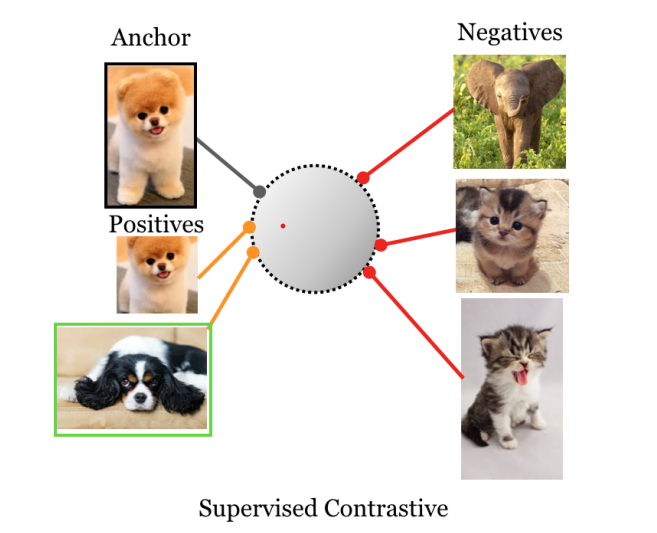


This is a generalized form of Triplet Loss and N-pair Loss. We use multiple positives and negatives for each anchor.

Loss Function:
$$\mathcal{L}_{out}^{sup} = \sum_{i  \in  I} \mathcal{L}_{out, i}^{sup} = \sum_{i \in I} \frac{-1}{\lvert P(i) \rvert} \sum_{p \in P(i)} log \frac{exp (z_i \cdot z_p / \tau)}{\sum_{a \in A(i)} exp(z_i \cdot z_a / \tau)} $$

 $A(i) \equiv I \backslash \{i\}; P(i) \equiv \{p \in A(i): \tilde{y}_p = \tilde{y}_i \}$



In [ ]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point.
        # Edge case e.g.:-
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan]
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

<a name='train'></a>
# 6. Train Model

In [ ]:
criteria = SupConLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
loss_train=[]
loss_val=[]
def training(model, dataloader, val_dataloader, optimizer, criteria, epochs, device):
  model.to(device)
  best_val_loss = np.inf
  for epoch in range(1, epochs+1):
    model.train()
    total_train_loss = 0
    for img_paths, labels in tqdm(dataloader):
      augmented_imgs = []
      for img in img_paths:
        img = img.split('\t')
        augmented_imgs.append(train_transforms(Image.open(img[0])))
        augmented_imgs.append(train_transforms(Image.open(img[0])))
        augmented_imgs.append(train_transforms(Image.open(img[1])))
      augmented_imgs = torch.stack(augmented_imgs, dim = 0)
      labels = labels.repeat_interleave(3)

      imgs = augmented_imgs.to(device)
      labels = labels.to(device)

      features = model(imgs).unsqueeze(1)
      optimizer.zero_grad()
      loss = criteria(features, labels)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
    print('Epoch {}: Loss = {}'.format(epoch, total_train_loss/len(dataloader)))
    loss_train.append(total_train_loss/len(dataloader))


    model.eval()
    total_val_loss = 0
    for img_paths, labels in val_dataloader:
      with torch.no_grad():
        augmented_imgs = []
        for img in img_paths:
          img = img.split('\t')
          augmented_imgs.append(train_transforms(Image.open(img[0])))
          augmented_imgs.append(train_transforms(Image.open(img[0])))
          augmented_imgs.append(train_transforms(Image.open(img[1])))
        augmented_imgs = torch.stack(augmented_imgs, dim = 0)
        labels = labels.repeat_interleave(3)

        imgs = augmented_imgs.to(device)
        labels = labels.to(device)

        features = model(imgs).unsqueeze(1)
        val_loss = criteria(features, labels)
        total_val_loss += val_loss.item()
    print('Evaluate: Val Loss = {}'.format(total_val_loss/len(val_dataloader)))
    loss_val.append(total_val_loss/len(val_dataloader))

    if total_val_loss < best_val_loss:
      best_val_loss = total_val_loss
      torch.save(model.state_dict(), 'model_best_weights_1000.pt')

training(model, train_dataloader, val_dataloader, optimizer, criteria, 3, device)

100%|██████████| 270/270 [09:40<00:00,  2.15s/it]


Epoch 1: Loss = 2.775479359538467
Evaluate: Val Loss = 5.4426169962745


100%|██████████| 270/270 [09:40<00:00,  2.15s/it]


Epoch 2: Loss = 2.1363743075618036
Evaluate: Val Loss = 5.163266147447936


100%|██████████| 270/270 [09:44<00:00,  2.17s/it]


Epoch 3: Loss = 1.9373901428999725
Evaluate: Val Loss = 5.193128384194574


<a name='evaluate'></a>
# 7. Evaluate Model

## Load Model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PRML/model_best_weights_1000.pt'))
model.to('cuda')
model.eval();

## Evaluate

In [ ]:
test_paths = []
for i in test_dataset:
  test_paths.append((i[0].split('\t')[0], i[1]))

len(test_paths)

19962

In [ ]:
os.mkdir('./test_embeddings')

In [ ]:
test_store = []
i = 0
for (img_path, identity) in test_paths:
    embedding = model(val_transforms(Image.open(img_path)).unsqueeze(0).to('cuda')).cpu().detach().numpy().squeeze(0)
    test_store.append(embedding)
    if len(test_store) == 500:
        embeddings = np.vstack(test_store)
        np.save('./test_embeddings/embeddings{}.npy'.format(i), embeddings)
        i += 1
        test_store = []

if len(test_store) > 0:
    embeddings = np.vstack(test_store)
    np.save('./test_embeddings/embeddings{}.npy'.format(i), embeddings)
model.to('cpu');
# i = i + 1

In [ ]:
filenames = ['./test_embeddings/embeddings{}.npy'.format(j) for j in range(40)]
test_final_embeddings = np.vstack([np.load(filenames[j]) for j in range(40)])
np.save('./test_embeddings/final_embeddings.npy', test_final_embeddings)

In [ ]:
len(test_final_embeddings)

19962

---------

Similarity search with  **Faiss**  (Facebook AI Similarity Search)


[https://github.com/facebookresearch/faiss](https://github.com/facebookresearch/faiss)


[https://github.com/facebookresearch/faiss/wiki/Faiss-indexes](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)

In [ ]:
import faiss
index = faiss.IndexFlatIP(512)
index.add(test_final_embeddings)
index.ntotal

19962

### P@K

$$ Precision \ at \ k \ (P@K) \ = \frac{Number \ of \ relevent \ items \ in \ k}{Total \ numbers \ of \ items \ in \ k}$$

In [ ]:
def evaluate(test_dataloader, model, index, k=3):
  PreK=[]
  d=1
  for paths, labels in test_dataloader:
    _labels=labels.tolist()

    prek=[]
    for stt, _path in enumerate(paths):
      path=_path.split('\t')[0]
      query = model(val_transforms(Image.open(path)).unsqueeze(0)).detach().numpy()
      D, I = index.search(query, k=k)
      yes_labels=0
      for i, idx in enumerate(I[0]):
        retrieved_image_path = test_paths[idx][0]
        label = test_paths[idx][1]
        if label==_labels[stt]:
          yes_labels+=1
      if len(test_dct[str(_labels[stt])]) <k :
        prek.append(yes_labels/len(test_dct[str(_labels[stt])]))
      else:
        prek.append(yes_labels/k)
    PreK.append(sum(prek)/len(prek))
    print("Batch {} P@K (P@{}):______ {}".format(d,k,round(sum(prek)/len(prek),2)))
    d=d+1

  return PreK





In [ ]:
PreK=evaluate(test_dataloader,model,index,9)

Batch 1 P@K (P@9):______ 0.76
Batch 2 P@K (P@9):______ 0.85
Batch 3 P@K (P@9):______ 0.84
Batch 4 P@K (P@9):______ 0.66
Batch 5 P@K (P@9):______ 0.66
Batch 6 P@K (P@9):______ 0.68
Batch 7 P@K (P@9):______ 0.79
Batch 8 P@K (P@9):______ 0.73
Batch 9 P@K (P@9):______ 0.66
Batch 10 P@K (P@9):______ 0.79
Batch 11 P@K (P@9):______ 0.92
Batch 12 P@K (P@9):______ 0.81
Batch 13 P@K (P@9):______ 0.78
Batch 14 P@K (P@9):______ 0.86
Batch 15 P@K (P@9):______ 0.72
Batch 16 P@K (P@9):______ 0.86
Batch 17 P@K (P@9):______ 0.9
Batch 18 P@K (P@9):______ 0.73
Batch 19 P@K (P@9):______ 0.73
Batch 20 P@K (P@9):______ 0.8
Batch 21 P@K (P@9):______ 0.48
Batch 22 P@K (P@9):______ 0.61
Batch 23 P@K (P@9):______ 0.78
Batch 24 P@K (P@9):______ 0.7
Batch 25 P@K (P@9):______ 0.93
Batch 26 P@K (P@9):______ 0.92
Batch 27 P@K (P@9):______ 0.78
Batch 28 P@K (P@9):______ 0.9
Batch 29 P@K (P@9):______ 0.64
Batch 30 P@K (P@9):______ 0.82
Batch 31 P@K (P@9):______ 0.89
Batch 32 P@K (P@9):______ 0.72
Batch 33 P@K (P@9):__

In [ ]:
sum(PreK)/len(PreK)

0.7557204780248287

### AP@K

 **Average Precision@K**

$$ AP@K = \frac{1}{K} \sum_{i=1}^{K}
 P@i$$

In [ ]:
def evaluate_APK(test_dataloader,model, index, k=3):
  meanAPK=[]
  d=1
  for paths, labels in test_dataloader:
    _labels=labels.tolist()

    APK=[]
    for kk in range(1,k+1):
      prek=[]
      for stt, _path in enumerate(paths):
        path=_path.split('\t')[0]
        query = model(val_transforms(Image.open(path)).unsqueeze(0)).detach().numpy()
        D, I = index.search(query, k=kk)
        yes_labels=0
        for i, idx in enumerate(I[0]):
          retrieved_image_path = test_paths[idx][0]
          label = test_paths[idx][1]
          if label==_labels[stt]:
            yes_labels+=1
        if len(test_dct[str(_labels[stt])]) <kk :
          prek.append(yes_labels/len(test_dct[str(_labels[stt])]))
        else:
          prek.append(yes_labels/kk)
        APK.append(sum(prek)/len(prek))

    print("Batch {} AP@K (AP@{}):______ {}".format(d,k,round(sum(APK)/len(APK),2)))
    d=d+1
    meanAPK.append(round(sum(APK)/len(APK),2))

  return meanAPK

In [ ]:
kq=evaluate_APK(test_dataloader,model,index, k=3)

Batch 1 AP@K (AP@3):______ 0.98
Batch 2 AP@K (AP@3):______ 0.96
Batch 3 AP@K (AP@3):______ 0.96
Batch 4 AP@K (AP@3):______ 0.89
Batch 5 AP@K (AP@3):______ 0.85
Batch 6 AP@K (AP@3):______ 0.93
Batch 7 AP@K (AP@3):______ 0.96
Batch 8 AP@K (AP@3):______ 0.96
Batch 9 AP@K (AP@3):______ 0.92
Batch 10 AP@K (AP@3):______ 0.94
Batch 11 AP@K (AP@3):______ 0.99
Batch 12 AP@K (AP@3):______ 0.95
Batch 13 AP@K (AP@3):______ 0.96
Batch 14 AP@K (AP@3):______ 0.98
Batch 15 AP@K (AP@3):______ 0.83
Batch 16 AP@K (AP@3):______ 0.96
Batch 17 AP@K (AP@3):______ 0.99
Batch 18 AP@K (AP@3):______ 0.94
Batch 19 AP@K (AP@3):______ 0.95
Batch 20 AP@K (AP@3):______ 0.91
Batch 21 AP@K (AP@3):______ 0.81
Batch 22 AP@K (AP@3):______ 0.86
Batch 23 AP@K (AP@3):______ 0.92
Batch 24 AP@K (AP@3):______ 0.91
Batch 25 AP@K (AP@3):______ 0.99
Batch 26 AP@K (AP@3):______ 0.96
Batch 27 AP@K (AP@3):______ 0.91
Batch 28 AP@K (AP@3):______ 0.97
Batch 29 AP@K (AP@3):______ 0.88
Batch 30 AP@K (AP@3):______ 0.91
Batch 31 AP@K (AP@3

In [ ]:
sum(kq)/len(kq)

0.9340384615384616

### P@K with ID

In [ ]:
k=9
PreK_Avare=[]
A=list(test_dct.keys())
for idd in range(len(A)):
  id=int(A[idd])
  path=test_dct[str(id)]
  prek=[]
  for _path in path:
    query = model(val_transforms(Image.open(_path)).unsqueeze(0)).detach().numpy()
    D, I = index.search(query, k=k)
    yes_labels=0
    for i, idx in enumerate(I[0]):
      retrieved_image_path = test_paths[idx][0]
      label = test_paths[idx][1]
      if label==id:
        yes_labels+=1
    if len(test_dct[str(id)]) <k :
      prek.append(yes_labels/len(test_dct[str(id)]))
    else:
      prek.append(yes_labels/k)
  PreK_Avare.append(sum(prek)/len(prek))
  print("Precision Top {} of id: {}= {}".format(k,id,round(sum(prek)/len(prek),2)))

Precision Top 9 of id: 7760= 0.94
Precision Top 9 of id: 7988= 0.58
Precision Top 9 of id: 5858= 0.54
Precision Top 9 of id: 4930= 0.98
Precision Top 9 of id: 6192= 0.69
Precision Top 9 of id: 9739= 0.87
Precision Top 9 of id: 7407= 0.73
Precision Top 9 of id: 10154= 0.91
Precision Top 9 of id: 6190= 0.9
Precision Top 9 of id: 7862= 0.37
Precision Top 9 of id: 5872= 0.86
Precision Top 9 of id: 5010= 0.59
Precision Top 9 of id: 6221= 0.41
Precision Top 9 of id: 8659= 0.85
Precision Top 9 of id: 9411= 0.82
Precision Top 9 of id: 5941= 0.69
Precision Top 9 of id: 5241= 0.37
Precision Top 9 of id: 5774= 0.87
Precision Top 9 of id: 8777= 0.69
Precision Top 9 of id: 8533= 0.92
Precision Top 9 of id: 10001= 0.71
Precision Top 9 of id: 6177= 0.6
Precision Top 9 of id: 9603= 0.5
Precision Top 9 of id: 5301= 0.81
Precision Top 9 of id: 5624= 0.52
Precision Top 9 of id: 7712= 0.66
Precision Top 9 of id: 9874= 0.9
Precision Top 9 of id: 8154= 0.98
Precision Top 9 of id: 8745= 0.93
Precision Top 9 

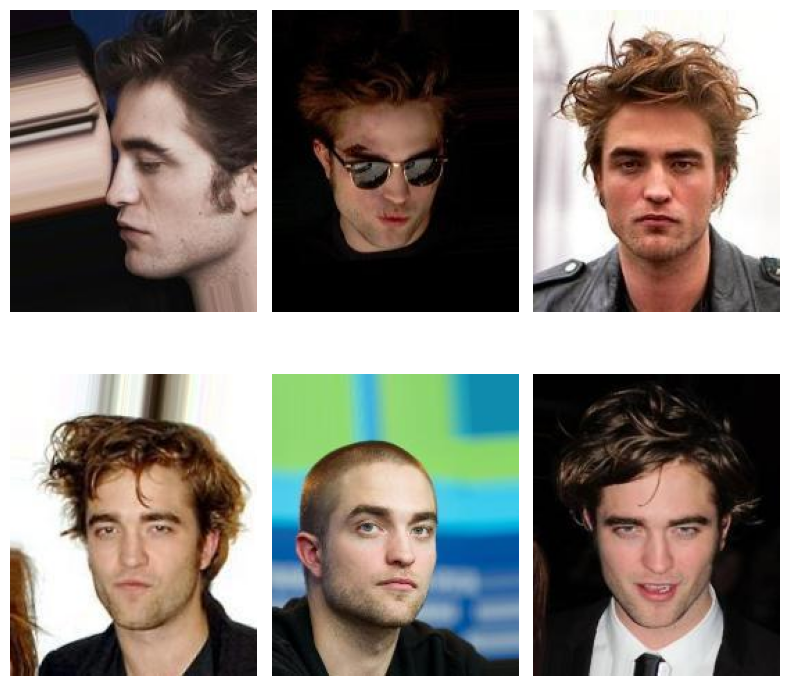

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8))
axes = axes.flatten()

for i,path in enumerate(test_dct['8146']):
    img = np.array(Image.open(path))
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

<a name='test'></a>
# 8. Test Model

7816


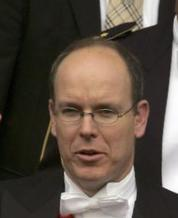

In [ ]:
idx =np.random.randint(len(test_paths))
path, label = test_paths[idx]
# path=
query = model(val_transforms(Image.open(path)).unsqueeze(0)).detach().numpy()
D, I = index.search(query, k=9)
print(label)
Image.open(path)

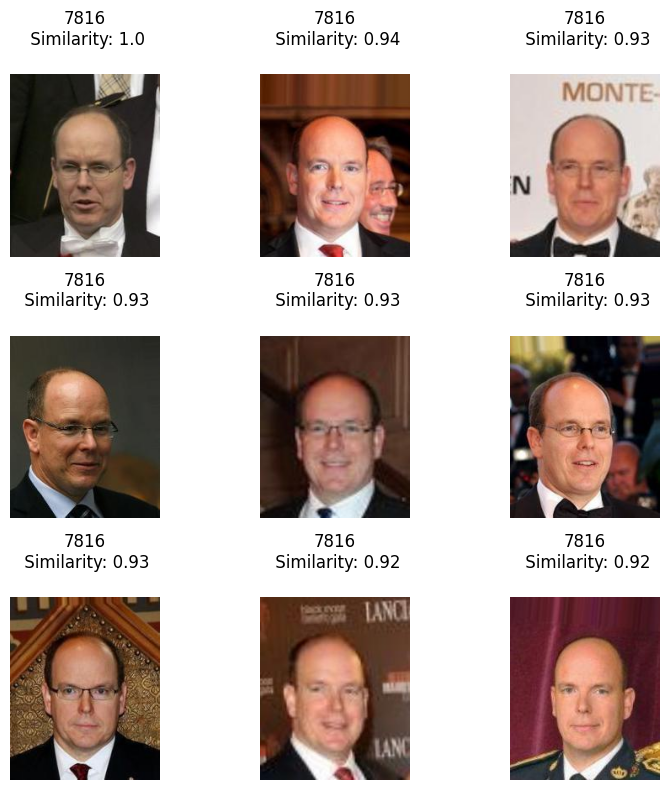

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, idx in enumerate(I[0]):
    retrieved_image_path = test_paths[idx][0]
    label = test_paths[idx][1]
    img = np.array(Image.open(retrieved_image_path))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(str(label) +'\n Similarity: '+ str(round(D[0][i],2) )+ '\n')

plt.tight_layout()
plt.show()

<a name='pretrain'></a>
# 9. Pretrained Model in VGGFace2 dataset

In [ ]:
model2 = SiameseModel()
rand_img = torch.rand((5,3,160,160))
model2(rand_img).shape

torch.Size([5, 512])

In [ ]:
os.mkdir('./test_embeddings')

In [ ]:
model2.to("cuda");
model2.eval();

In [ ]:
test_store = []
i = 0
for (img_path, identity) in test_paths:
    embedding = model2(val_transforms(Image.open(img_path)).unsqueeze(0).to('cuda')).cpu().detach().numpy().squeeze(0)
    test_store.append(embedding)
    if len(test_store) == 500:
        embeddings = np.vstack(test_store)
        np.save('./test_embeddings/embeddings2{}.npy'.format(i), embeddings)
        i += 1
        test_store = []

if len(test_store) > 0:
    embeddings = np.vstack(test_store)
    np.save('./test_embeddings/embeddings2{}.npy'.format(i), embeddings)

i = i + 1

In [ ]:
filenames = ['./test_embeddings/embeddings2{}.npy'.format(j) for j in range(40)]
test_final_embeddings = np.vstack([np.load(filenames[j]) for j in range(40)])
np.save('./test_embeddings/final_embeddings2.npy', test_final_embeddings)
model2.to('cpu');

In [ ]:

index2 = faiss.IndexFlatIP(512)
index2.add(test_final_embeddings)
index2.ntotal

19962

-----

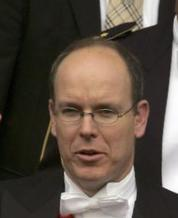

In [ ]:
path=test_dct['7816'][11]

query = model2(val_transforms(Image.open(path)).unsqueeze(0)).detach().numpy()
D, I = index2.search(query, k=9)
Image.open(path)

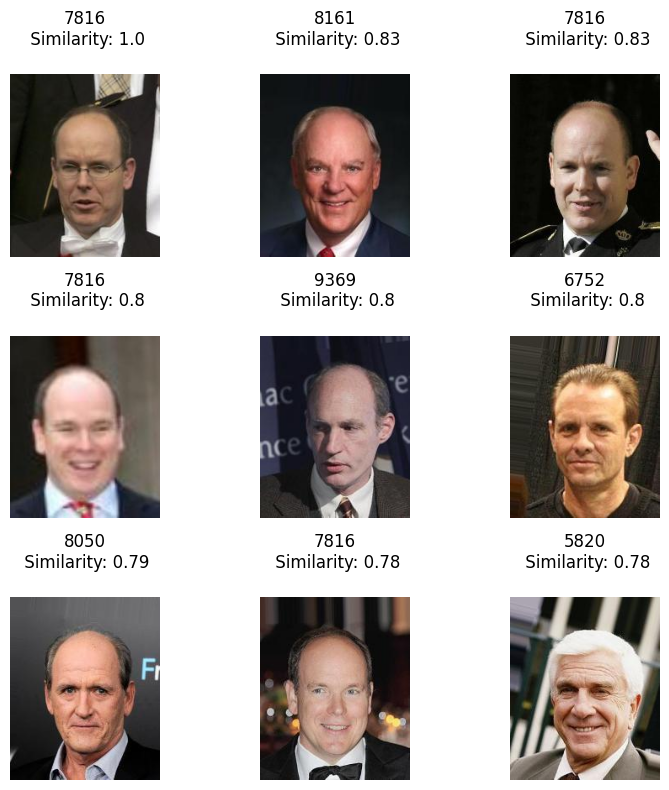

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, idx in enumerate(I[0]):
    retrieved_image_path = test_paths[idx][0]
    label = test_paths[idx][1]
    # print(retrieved_image_path)
    img = np.array(Image.open(retrieved_image_path))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(str(label) +'\n Similarity: '+ str(round(D[0][i],2) )+ '\n')

# Hiển thị bảng ảnh
plt.tight_layout()
plt.show()

In [ ]:
pk2=evaluate(test_dataloader,model2,index2,k=9)

Batch 1 P@K (P@9):______ 0.51
Batch 2 P@K (P@9):______ 0.68
Batch 3 P@K (P@9):______ 0.59
Batch 4 P@K (P@9):______ 0.58
Batch 5 P@K (P@9):______ 0.5
Batch 6 P@K (P@9):______ 0.48
Batch 7 P@K (P@9):______ 0.68
Batch 8 P@K (P@9):______ 0.53
Batch 9 P@K (P@9):______ 0.41
Batch 10 P@K (P@9):______ 0.64
Batch 11 P@K (P@9):______ 0.7
Batch 12 P@K (P@9):______ 0.65
Batch 13 P@K (P@9):______ 0.72
Batch 14 P@K (P@9):______ 0.66
Batch 15 P@K (P@9):______ 0.58
Batch 16 P@K (P@9):______ 0.72
Batch 17 P@K (P@9):______ 0.83
Batch 18 P@K (P@9):______ 0.55
Batch 19 P@K (P@9):______ 0.48
Batch 20 P@K (P@9):______ 0.75
Batch 21 P@K (P@9):______ 0.32
Batch 22 P@K (P@9):______ 0.4
Batch 23 P@K (P@9):______ 0.72
Batch 24 P@K (P@9):______ 0.44
Batch 25 P@K (P@9):______ 0.84
Batch 26 P@K (P@9):______ 0.83
Batch 27 P@K (P@9):______ 0.63
Batch 28 P@K (P@9):______ 0.8
Batch 29 P@K (P@9):______ 0.47
Batch 30 P@K (P@9):______ 0.71
Batch 31 P@K (P@9):______ 0.65
Batch 32 P@K (P@9):______ 0.41
Batch 33 P@K (P@9):__

In [ ]:
sum(pk2)/len(pk2)

0.5831470610228688

<a name='saliency'></a>
# 10. Visual Explaination with Similarity-based Saliency Map (SBSM)

 [Explainable, interactive content-based image retrieval](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Explainable%20AI/Dong_Explainability_for_Content-Based_Image_Retrieval_CVPRW_2019_paper.pdf). 

![](https://www.researchgate.net/publication/355469752/figure/fig2/AS:11431281179410304@1691190639543/Similarity-based-saliency-map-SBSM-generation-Result-image-R-is-masked-by-binary-mask.png)





In [ ]:
import numpy as np
import torch
import torch.nn as nn


class SBSM(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(SBSM, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, window_size, stride, savepath='masks.npy'):
        """
        Generates sliding window type binary masks used in augment() to
        mask an image. The Images are resized to 160x160 to
        enable re-use of masks Generating the sliding window style masks.
        :param int window_size: the block window size
        (with value 0, other areas with value 1)
        :param int stride: the sliding step
        :param tuple image_size: the mask size which should be the
        same to the image size
        :return: the sliding window style masks
        :rtype: numpy.ndarray
        """

        rows = np.arange(0 + stride - window_size, self.input_size[0], stride)
        cols = np.arange(0 + stride - window_size, self.input_size[1], stride)

        mask_num = len(rows) * len(cols)
        masks = np.ones(
            (mask_num, self.input_size[0], self.input_size[1]), dtype=np.uint8)
        i = 0
        for r in rows:
            for c in cols:
                if r < 0:
                    r1 = 0
                else:
                    r1 = r
                if r + window_size > self.input_size[0]:
                    r2 = self.input_size[0]
                else:
                    r2 = r + window_size
                if c < 0:
                    c1 = 0
                else:
                    c1 = c
                if c + window_size > self.input_size[1]:
                    c2 = self.input_size[1]
                else:
                    c2 = c + window_size
                masks[i, r1:r2, c1:c2] = 0
                i += 1
        masks = masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, masks)
        self.register_buffer('masks', torch.from_numpy(masks).cuda())
        self.N = self.masks.shape[0]
        self.window_size = window_size
        self.stride = stride

    def load_masks(self, filepath):
        masks = np.load(filepath)
        self.register_buffer('masks', torch.from_numpy(masks).cuda())
        self.N = self.masks.shape[0]

    def weighted_avg(self, K):
        count = self.N - self.masks.sum(dim=(0, 1))
        sal = K.sum(dim=-1).permute(2, 0, 1) / count

        return sal

    def forward(self, x_q, x):
        with torch.no_grad():
            # Get embedding of query and retrieval image
            x_q = self.model(x_q)
            x_r = self.model(x)
            o_dist = torch.cdist(x_q, x_r)

            # Apply array of masks to the image
            stack = torch.mul(self.masks, x)

            x = []
            for i in range(0, self.N, self.gpu_batch):
                x.append(self.model(stack[i:min(i + self.gpu_batch, self.N)]))
            x = torch.cat(x)
            m_dist = torch.cdist(x_q, x)

            # Compute saliency
            K = (1 - self.masks).permute(2, 3, 1, 0) * \
                (m_dist - o_dist).clamp(min=0)
            sal = self.weighted_avg(K)

        return sal

In [ ]:
import os

explainer = SBSM(model, input_size=(160, 160), gpu_batch=100)

maskspath = 'masks.npy'
if not os.path.isfile(maskspath):
    explainer.generate_masks(window_size=24, stride=5, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Select two images with the same face to observe the operation of the saliency map

In [ ]:
import random

idx = random.choice(list(test_dct.keys()))
query_path, retrieval_path = random.choices(test_dct[idx], k=2)

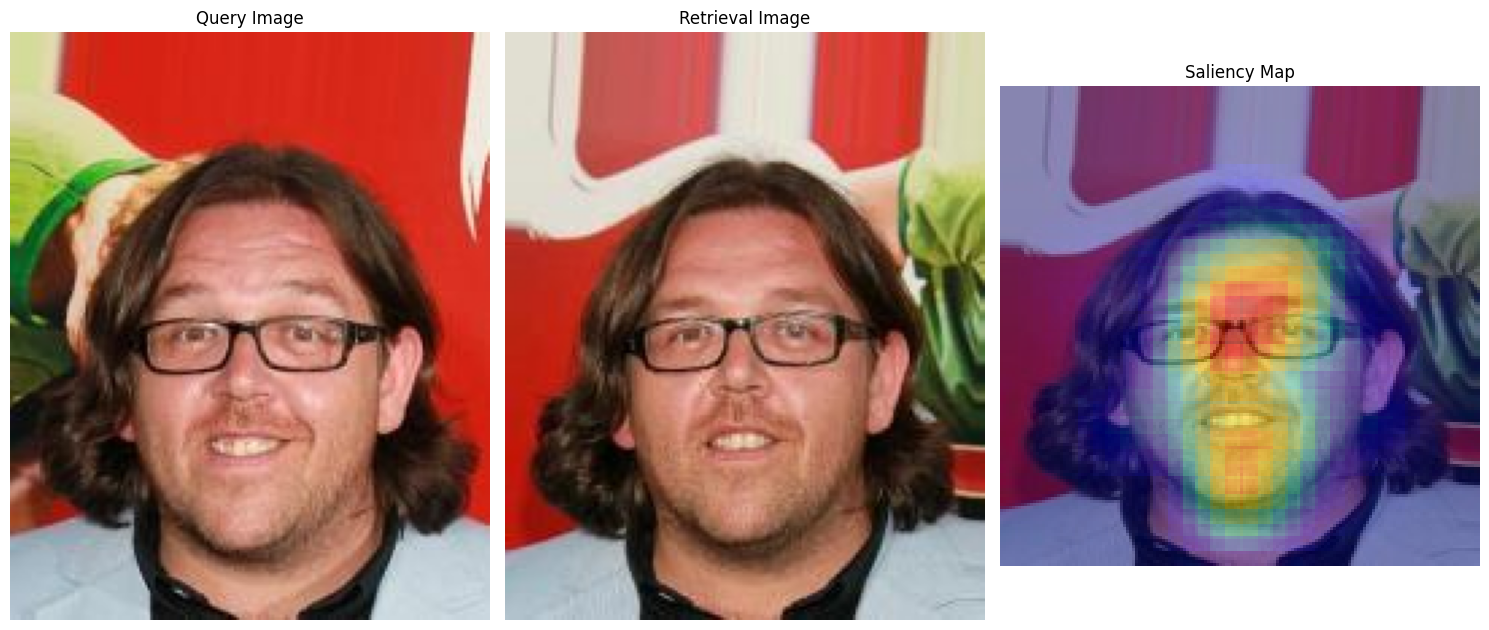

In [ ]:
# Resize image
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

query_img, retrieval_img = Image.open(query_path), Image.open(retrieval_path)
query, retrieval = transform(query_img), transform(retrieval_img)
query, retrieval = query.unsqueeze(0).to('cuda'), retrieval.unsqueeze(0).to('cuda')

salmap = explainer(query, retrieval).cpu().numpy()[0, :, :]

fig, ax = plt.subplots(1, 3, figsize=(15, 12))

# Query Image
ax[0].imshow(query_img)
ax[0].set_title('Query Image')
ax[0].axis('off')

# Retrieval Image
ax[1].imshow(retrieval_img)
ax[1].set_title('Retrieval Image')
ax[1].axis('off');

# Saliency Map
retrieval_img = retrieval_img.resize((160, 160))
ax[2].imshow(retrieval_img, interpolation='none')
ax[2].imshow(salmap, cmap='jet', interpolation='none', alpha=0.4)
ax[2].set_title('Saliency Map')
ax[2].axis('off');

plt.tight_layout();

Face Image Retrieval with Saliency Map

In [ ]:
from PIL import Image
import torchvision.transforms as tf
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

def image_search(query_path, k=5):
    query_img = Image.open(query_path)

    plt.imshow(query_img)
    plt.axis('off')
    plt.title('Query Image')

    transform = tf.Compose([
        tf.Resize((160, 160)),
        tf.ToTensor()
    ])

    query_img = transform(query_img)
    query_img = torch.unsqueeze(query_img, 0)

    query_img = query_img.to('cuda')

    model.eval()
    query_vec = model(query_img).cpu().detach().numpy()

    D, I = index.search(query_vec, k=k)
    ids = I[0]

    # Create binary mask to calc saliency map
    explainer = SBSM(model, input_size=(160, 160), gpu_batch=100)

    maskspath = 'masks.npy'
    if not os.path.isfile(maskspath):
        explainer.generate_masks(window_size=24, stride=5, savepath=maskspath)
    else:
        explainer.load_masks(maskspath)
        print('Masks are loaded.')


    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    axes = axes.flatten()

    for i, idx in enumerate(ids):
        path, _= test_paths[idx]

        image = Image.open(path)
        img = transform(image)
        img = torch.unsqueeze(img, 0)
        img = img.to('cuda')

        salmap = explainer(query_img, img)

        # convert to numpy
        salmap = salmap.cpu().numpy()
        salmap = salmap[0, :, :]

        resize_transform = tf.Resize((160, 160))
        image = resize_transform(image)


        norm = mpl.colors.Normalize()
        sal_img = Image.fromarray(np.uint8(cm.jet(norm(salmap)) * 255), 'RGBA')
        sal_img.putalpha(100)
        image = image.convert('RGBA')
        saliency_map = Image.alpha_composite(image, sal_img)
        im = np.vstack([image, saliency_map])

        axes[i].imshow(im)
        axes[i].axis('off')

    fig.suptitle('Retrieval Images with Saliency Map', fontsize=16)
    plt.tight_layout()

Masks are loaded.


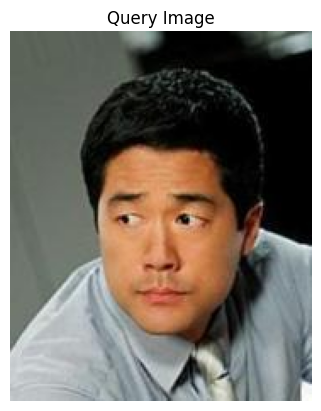

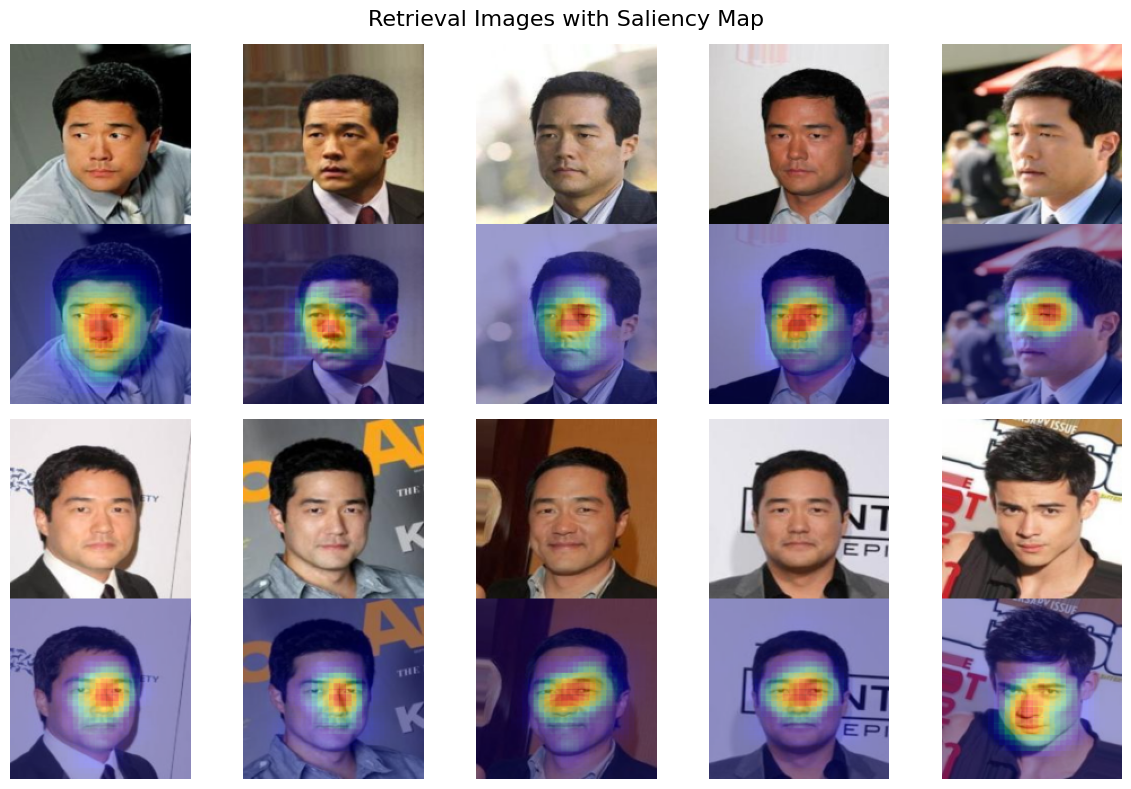

In [ ]:
query_path, _ = random.choice(test_paths)

image_search(query_path, k = 10)

<a name='demo'></a>
# 11. Face CBIR system - Demo

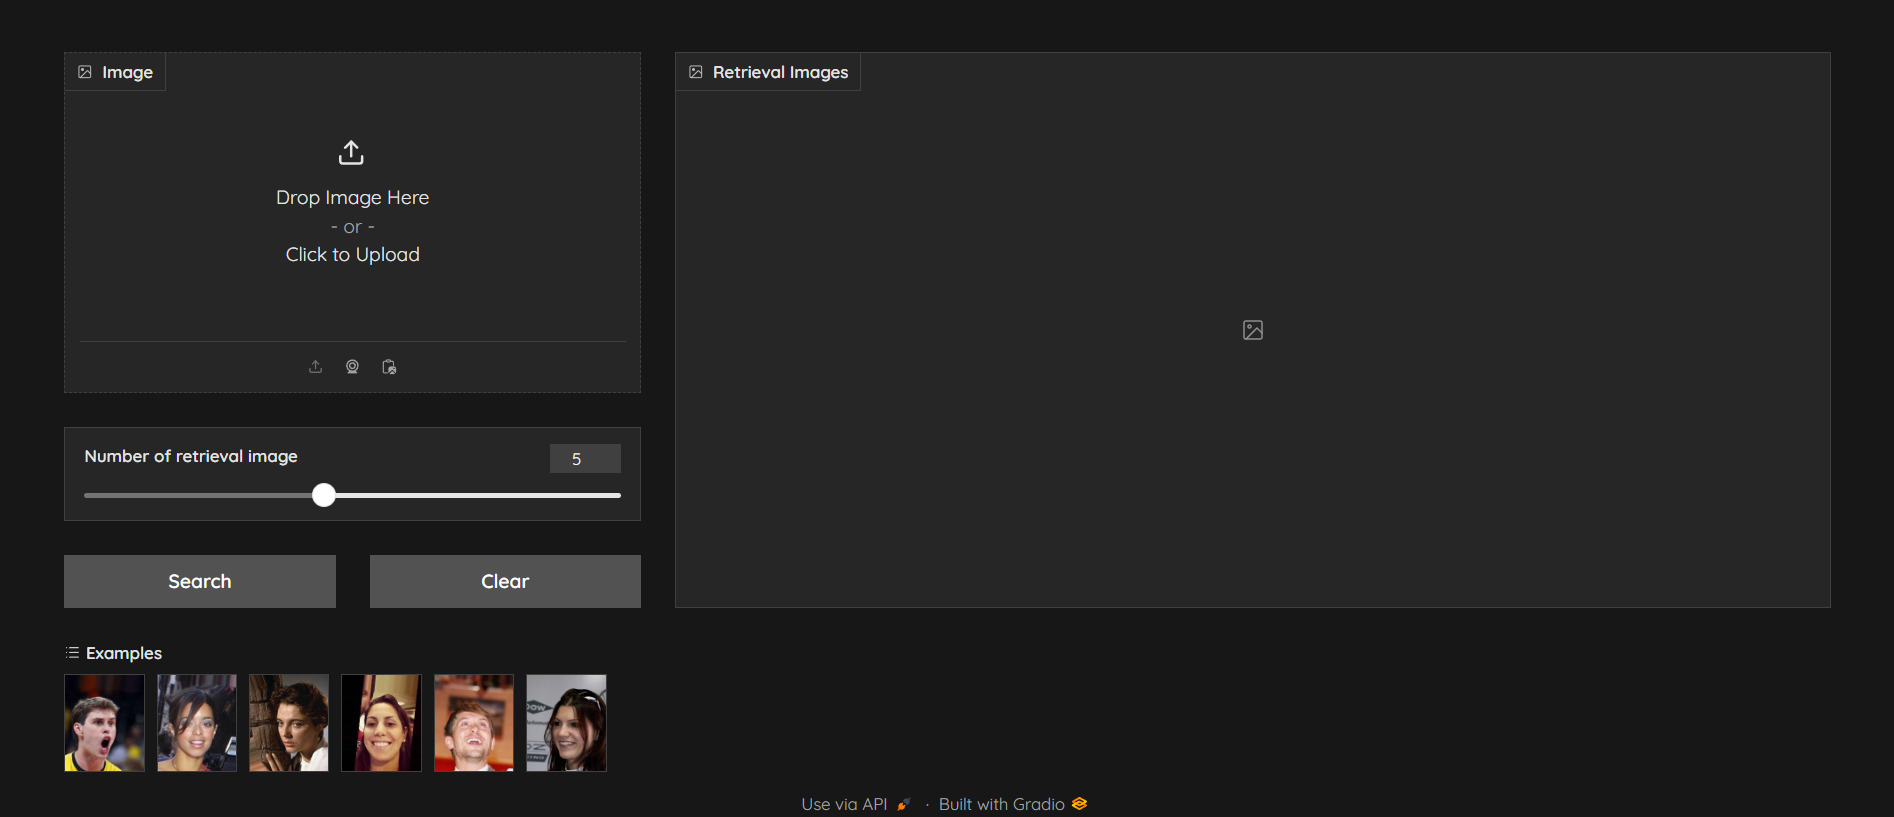

<a name='challenge'></a>
# 12. Challenge

- **Regarding the CelebA dataset**, it consists of faces of celebrities collected from various sources, including photos taken at events, images from social media, and pictures cut from magazines. Consequently, the dataset itself is not free from limitations such as:
  - Faces captured at various angles: frontal, tilted, etc.
  - Some facial images may be blurred, have low resolution, accompanied by text (*cut from magazines, posters, etc.*).
  - Faces captured in challenging lighting conditions, such as low light or backlight.
  - Presence of accessories in facial images, such as glasses, hats, etc.
  - Some faces may appear relatively similar, making it challenging to distinguish.
  - Inclusion of images of famous personalities at different stages of life.
  - Limited representation of child images.
  - Imbalance in the dataset, with some individuals having fewer than 5 images and others having more than 10.

- **Regarding query images**
  - The clarity of query images determines the success of retrieval; sharper query images yield better results.

- **Regarding resources**
  - Memory and GPU usage time on platforms like Colab/Kaggle are limited.

<a name='future'></a>
# 13. Future Improve

![](https://github.com/PyRetri/PyRetri/raw/master/teaser_image/overview.png)

- You can explore alternative models in two directions:
  - Utilize a CNN-based backbone model such as MobileNet, DenseNet, Inception, ResNet, etc., and fine-tune the model on a larger dataset depending on available resources and time.
  - Utilize existing multimodal Vision Transformer models from HuggingFace, which may yield better results, such as OpenAI CLIP, Facebook DINOv2.

- Techniques to improve the accuracy of the model include:
  - Aggregation
  - Dimension Process
  - Rerank
  - Human-in-the-loop
  - ...